# Setup

In [73]:
import os
import sys
import joblib
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

import yaml

import warnings
warnings.filterwarnings("ignore")

# Creating classes

## Data Explorer

In [74]:
class DataExplorer:
    @staticmethod
    def explore_data(data):
        print(data.head().T)
        print(data.describe())
        print(data.info())
        
    @staticmethod
    def clear(data):
        #We can see there are a few records with namespacing between the column name, so we need to make a trim
        columns_clean = [i.strip() for i in data.columns.values.tolist()]
        data.columns = columns_clean
    
    @staticmethod
    def basic_vis(data):
        
        data['shares'].values
        data["n_tokens_content"].plot(kind = "box")
        plt.show()
        data.mean(axis=0)
        data['n_tokens_title'].plot(kind = "hist")
        plt.show()
        print("******************************************skew*************************************************")
        data.skew()
        print("****************************************kurtosis***********************************************")
        data.kurtosis()
    
    @staticmethod
    def plot_histograms(data):
        data.hist(bins=50, figsize=(25, 25))
        plt.show()

        insight1="A couple of comments: Different scales, some features do not have the necessary values to see generate a histogram"
        insight2="for example week_is_monday altough is a numeric value, is a binary feature , but others like num_keywords have few categories"
        insight3="so the histogram is not possible to see a well-generated curve For a first model, we'll take into account the following numerical features:"
        insight4="n_tokens_content num_hrefs average_token_length kw_avg_max global_subjectivity , global_sentiment_polarity , global_rate_positive_words , global_rate_negative_words"
        insight5="rate_positive_words , rate_negative_words avg_positive_polarity , avg_negative_polarity Binary features: data_channel_is_lifestyle, data_channel_is_entertainment,"
        insight6="data_channel_is_bus, data_channel_is_socmed data_channel_is_tech, data_channel_is_world , weekday_is_monday, weekday_is_tuesday, weekday_is_wednesday"
        insight7="weekday_is_thursday, weekday_is_friday, weekday_is_saturday, weekday_is_sunday"

        print(insight1)
        print(insight2)
        print(insight3)
        print(insight4)
        print(insight5)
        print(insight6)
        
    @staticmethod
    def columns_numeric():
        cols_names_numeric = "n_tokens_content,num_hrefs,average_token_length,kw_avg_max,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,avg_negative_polarity".split(',')
        return cols_names_numeric

    @staticmethod
    def plot_correlation_matrix(data):
        cols_names_numeric=DataExplorer.columns_numeric()
        plt.figure(figsize=(10, 6))
        sbn.heatmap(data[cols_names_numeric].corr(), annot=True, fmt=".2f", cmap='coolwarm')
        plt.show()
        
    @staticmethod
    def otrosPlots(data):
        warnings.filterwarnings("ignore")
        sbn.set_style("whitegrid")
        sbn.set_palette("Spectral")

        # Define subplot grid
        #cols_names_numeric = "n_tokens_content,num_hrefs,average_token_length,kw_avg_max,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,avg_negative_polarity".split(',')
        cols_names_numeric=DataExplorer.columns_numeric()
        #cols_names_numeric="num_hrefs,average_token_length,kw_avg_max,global_subjectivity".split(',')
        fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
        plt.subplots_adjust(hspace=0.5)
        # loop through columns and axes
        for variable, ax in zip(cols_names_numeric, axs.ravel()):
            # filter df for column and plot on specified axes
            sbn.histplot(data[variable], ax=ax,kde_kws={'bw': 0.1})
            # chart formatting
            ax.set_title(variable.upper())
            ax.set_xlabel("")

        fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
        plt.subplots_adjust(hspace=0.5)

        for variable, ax in zip(cols_names_numeric, axs.ravel()):
            sbn.boxplot(x=variable,data=data,ax=ax)
            ax.set_title(variable.upper())
            ax.set_xlabel("")
        plt.show()
    
    @staticmethod
    def plots_after_transform(data):
        #Checking target value to see the distribution
        plt.hist(np.log2(data['shares']),bins=100)
        plt.xlabel('Shares')
        plt.show()
        data['shares'] = np.log2(data['shares'])
    
    @staticmethod
    def transformaciones_1(data):
          print("*********************************************Transformaciones***************************************************")
          cols_names_numeric= DataExplorer.columns_numeric()
          variables_a_transformar = cols_names_numeric[:11]
          n = len(variables_a_transformar)
          misdatos = data

          sbn.set(rc={'figure.figsize':(17,12)})
          fig, axes = plt.subplots(5, n)

          for k in range(0,n):
            # Datos originales ---------------------------------------------------------
            plt.subplot(5,n,k+1+(n*0))

            Transf0 = misdatos[variables_a_transformar[k]]  #  En esta línea se debe asignar a Transf0 los valores de cada variable "k" sin transformar.
            plt.hist(Transf0,bins=20)  #  En este línea agrega el comando para obtener el histograma de Transf0 con 20 barras (bins).
            plt.xlabel(variables_a_transformar[k])
            if k==0:
              plt.ylabel('Originales')

            # Datos transformados con raíz cuadrada ------------------------------------
            plt.subplot(5,n,k+1+(n*1))

            Transf1 = np.sqrt(misdatos[variables_a_transformar[k]])          #  En esta línea se debe aplicar la raíz cuadrada a los valores de cada variable "k" sin transformar.
            plt.hist(Transf1,bins=20)                    #  En este línea agrega el comando para obtener el histograma de Transf1 con 20 barras (bins).
            plt.xlabel(variables_a_transformar[k])
            if k==0:
              plt.ylabel('Raíz Cuadrada')

            # Datos transformados con logaritmo natural --------------------------------
            plt.subplot(5,n,k+1+(n*2))

            Transf2 = np.log1p(misdatos[variables_a_transformar[k]])         #  En esta línea se debe aplicar el logaritmo natural a los valores de cada variable "k" sin transformar.
            plt.hist(Transf2,bins=20)                    #  En este línea agrega el comando para obtener el histograma de Transf2 con 20 barras (bins).
            plt.xlabel(variables_a_transformar[k])
            if k==0:
              plt.ylabel('Logaritmo')

            # Datos transformados con la potencia de 2 ---------------------------------
            plt.subplot(5,n,k+1+(n*3))

            Transf3 = np.power(misdatos[variables_a_transformar[k]],2)          #  En esta línea debes elevar al cuadrado los valores de cada variable "k" sin transformar.
            plt.hist(Transf3,bins=20)                    #  En este línea agrega el comando para obtener el histograma de Transf3 con 20 barras (bins).
            plt.xlabel(variables_a_transformar[k])
            if k==0:
              plt.ylabel('Potencia 2')

            # Datos transformados con Box-Cox ------------------------------------------
            plt.subplot(5,n,k+1+(n*4))

            Transf4 = power_transform(misdatos[variables_a_transformar[k]].values.reshape(-1,1), method='yeo-johnson')       #  En esta línea se debe aplicar la transformación Box-Cox a los valores de cada variable "k" sin transformar.
            plt.hist(Transf4,bins=20)                    #  En este línea agrega el comando para obtener el histograma de Transf4 con 20 barras (bins).
            plt.xlabel(variables_a_transformar[k])
            if k==0:
              plt.ylabel('Yeo-Jhonson')

          plt.show()
    
    @staticmethod
    def transformaciones_2(data):
        print("As the last column named avg_negative_polarity has a lot of negative values, if we apply operations such as square root, or log2 ")
        print("We will get error, so the only option we have is to apply Yeo-Johnson, let's check if that can help")

        fig, axes = plt.subplots(1, 2)

        plt.subplot(1,2,1)
        trans = power_transform(data['avg_negative_polarity'].values.reshape(-1,1), method='yeo-johnson')
        plt.hist(trans,bins=20)
        plt.xlabel('avg_negative_polarity-Transformed')

        plt.subplot(1,2,2)
        plt.hist(data['avg_negative_polarity'],bins=20)
        plt.xlabel('avg_negative_polarity-Original')
        plt.show()


        insigh1="Puntos a destacar, podemos aplicar las siguientes transformaciones a las siguientes variables para corregir skew:"
        insigh2="Númericas - Standard Scaler para que todos los rangos esten entre 0 y 1"
        insigh3="num_hrefs - n_tokens_content -avg_positive_polarity - global_subjectivity - Logaritmo - np.log1p"
        insigh4="average_token_length - global_sentiment_polarity - Original "
        insigh5="kw_avg_max - global_rate_positive_words- Raiz Cuadrada"
        insigh6="global_rate_negative_words - rate_positive_words -rate_negative_words- Yeo Johnson "

        print(insigh1)
        print(insigh2)
        print(insigh3)
        print(insigh4)
        print(insigh5)
        print(insigh6)

## Online news model

In [75]:
class OnlineShares:
    def __init__(self, filepath):
        self.filepath = filepath
        self.model_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', RandomForestRegressor(n_estimators=160, max_depth=16, max_features='sqrt', min_samples_leaf=2, min_samples_split=2, random_state=42))
        ])
        self.X_train, self.X_test, self.y_train, self.y_test = [None] * 4

    def load_data(self):
        self.data = pd.read_csv(self.filepath)
        print('Exploring dataset')
        DataExplorer.explore_data(self.data)
        print('Data wrangling taks')
        DataExplorer.clear(self.data)
        print('Data visualization tasks')
        DataExplorer.basic_vis(self.data)
        print('Plotting histograms')
        DataExplorer.plot_histograms(self.data)
        print('Plotting correlation matrix')
        DataExplorer.plot_correlation_matrix(self.data)
        print('Other proposed plots')
        DataExplorer.otrosPlots(self.data)
        print('Transforming shares variable')
        DataExplorer.plots_after_transform(self.data)
        print('Applying tranformation to numerical features')
        DataExplorer.transformaciones_1(self.data)
        print('Applying tranformation to the last feature')
        DataExplorer.transformaciones_2(self.data)
        return self

    def preprocess_data(self):
        data = self.data
        X = data.drop('shares', axis=1)
        y = data['shares']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Transformaciones a columnas en X_train
        X_train['n_tokens_content'] = np.log1p(X_train['n_tokens_content'])
        X_train['num_hrefs'] = np.log1p(X_train['num_hrefs'])
        X_train['kw_avg_max'] = np.sqrt(X_train['kw_avg_max'])
        X_train['global_subjectivity'] = np.log1p(X_train['global_subjectivity'])
        X_train['global_rate_positive_words'] = np.sqrt(X_train['global_rate_positive_words'])

        # Columnas con Yeo-Johnson en X_train
        pt = PowerTransformer(method='yeo-johnson')

        X_train[['global_rate_negative_words', 'rate_positive_words', 'rate_negative_words']] = pt.fit_transform(
        X_train[['global_rate_negative_words', 'rate_positive_words', 'rate_negative_words']]
        )
        X_train['avg_positive_polarity'] = np.log1p(X_train['avg_positive_polarity'])

        # Transformaciones en X_test
        X_test['n_tokens_content'] = np.log1p(X_test['n_tokens_content'])
        X_test['num_hrefs'] = np.log1p(X_test['num_hrefs'])
        X_test['kw_avg_max'] = np.sqrt(X_test['kw_avg_max'])
        X_test['global_subjectivity'] = np.log1p(X_test['global_subjectivity'])
        X_test['global_rate_positive_words'] = np.sqrt(X_test['global_rate_positive_words'])

        # Aplicar Yeo-Johnson en X_test
        X_test[['global_rate_negative_words', 'rate_positive_words', 'rate_negative_words']] = pt.transform(
        X_test[['global_rate_negative_words', 'rate_positive_words', 'rate_negative_words']]
        )
        X_test['avg_positive_polarity'] = np.log1p(X_test['avg_positive_polarity'])

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        self.X_train, self.X_test, self.y_train, self.y_test = X_train , X_test, y_train, y_test

        return X_train_scaled, X_test_scaled, y_train, y_test
    
    def train_model(self, X_train_scaled, y_train):
        model = RandomForestRegressor(n_estimators=160, max_depth=16, max_features='sqrt', min_samples_leaf=2, min_samples_split=2, random_state=42)
        model.fit(X_train_scaled, y_train.values.ravel())
        return model
    
    def evaluate_model(self, model, X_test_scaled, y_test):
        predictions = model.predict(X_test_scaled)
        mse = mean_squared_error(y_test, predictions)
        print(f"Error Cuadrático Medio: {mse}")
    
    def cross_validate_model(self):
        scores = cross_val_score(self.model_pipeline, self.X_train, self.y_train, cv=5)
        print("Average Score with CV:", np.mean(scores))
        return self

## Executing code

Exploring dataset
                                        0           1            2  \
n_tokens_title                  12.000000    9.000000     9.000000   
n_tokens_content               219.000000  255.000000   211.000000   
n_unique_tokens                  0.663594    0.604743     0.575130   
n_non_stop_words                 1.000000    1.000000     1.000000   
n_non_stop_unique_tokens         0.815385    0.791946     0.663866   
num_hrefs                        4.000000    3.000000     3.000000   
num_self_hrefs                   2.000000    1.000000     1.000000   
num_imgs                         1.000000    1.000000     1.000000   
num_videos                       0.000000    0.000000     0.000000   
average_token_length             4.680365    4.913725     4.393365   
num_keywords                     5.000000    4.000000     6.000000   
data_channel_is_lifestyle        0.000000    0.000000     0.000000   
data_channel_is_entertainment    1.000000    0.000000     0.000000   
da

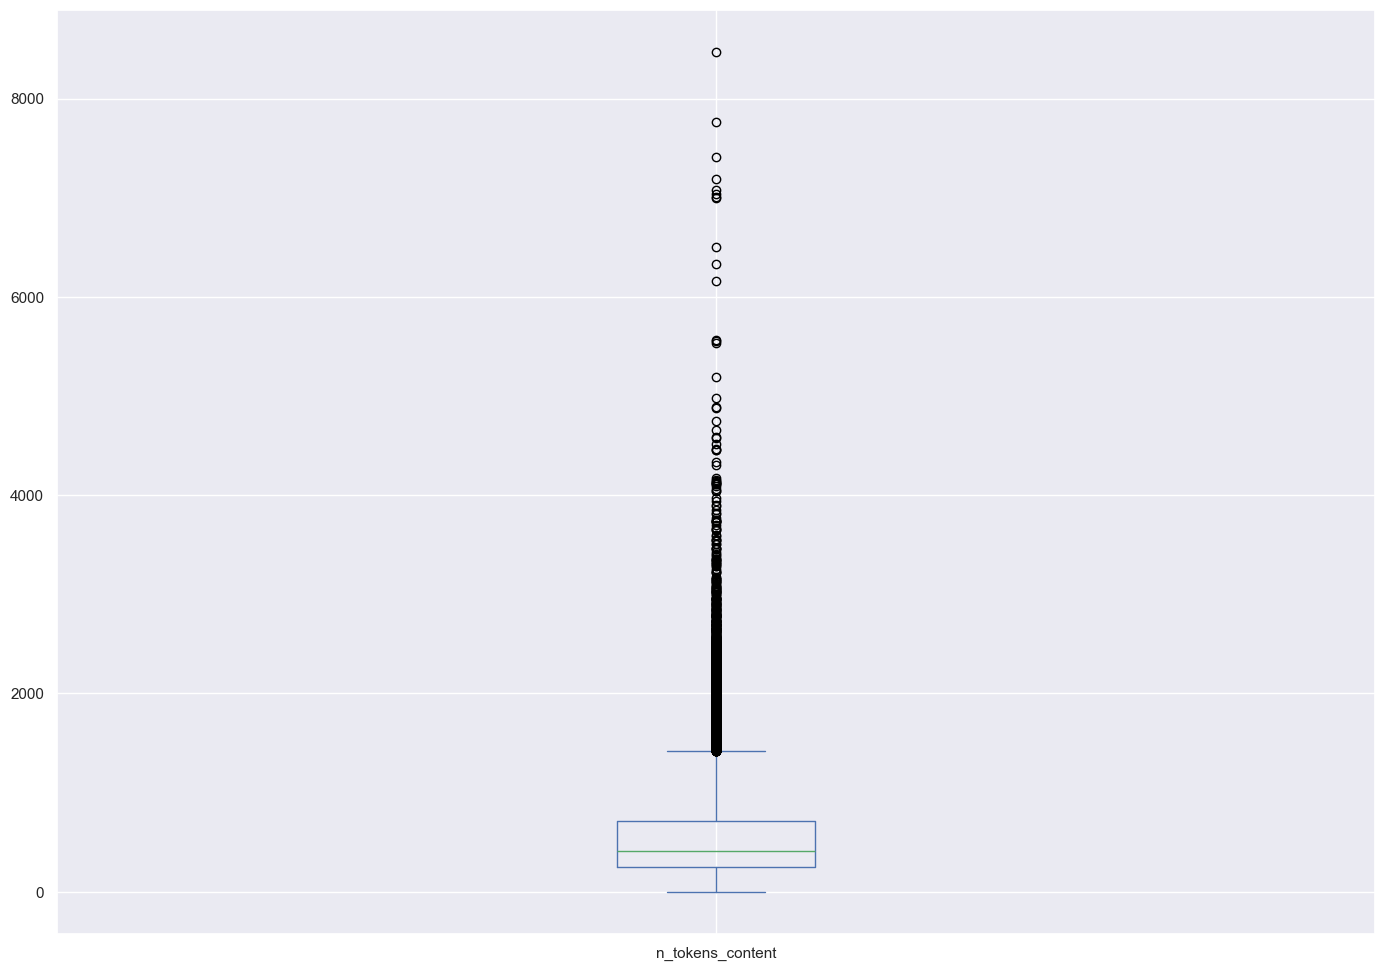

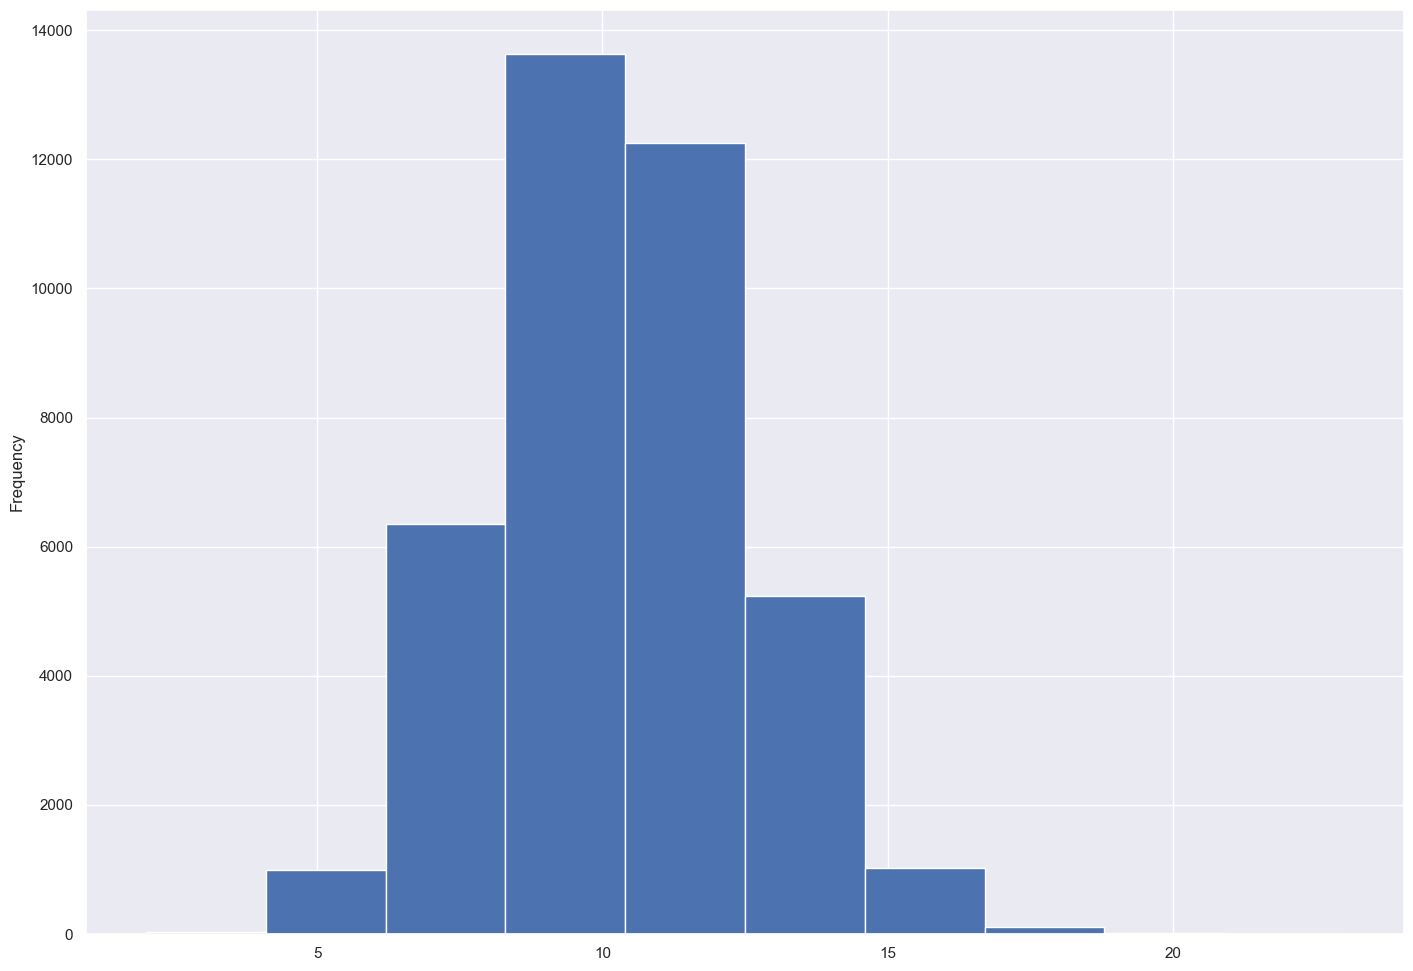

******************************************skew*************************************************
****************************************kurtosis***********************************************
Plotting histograms


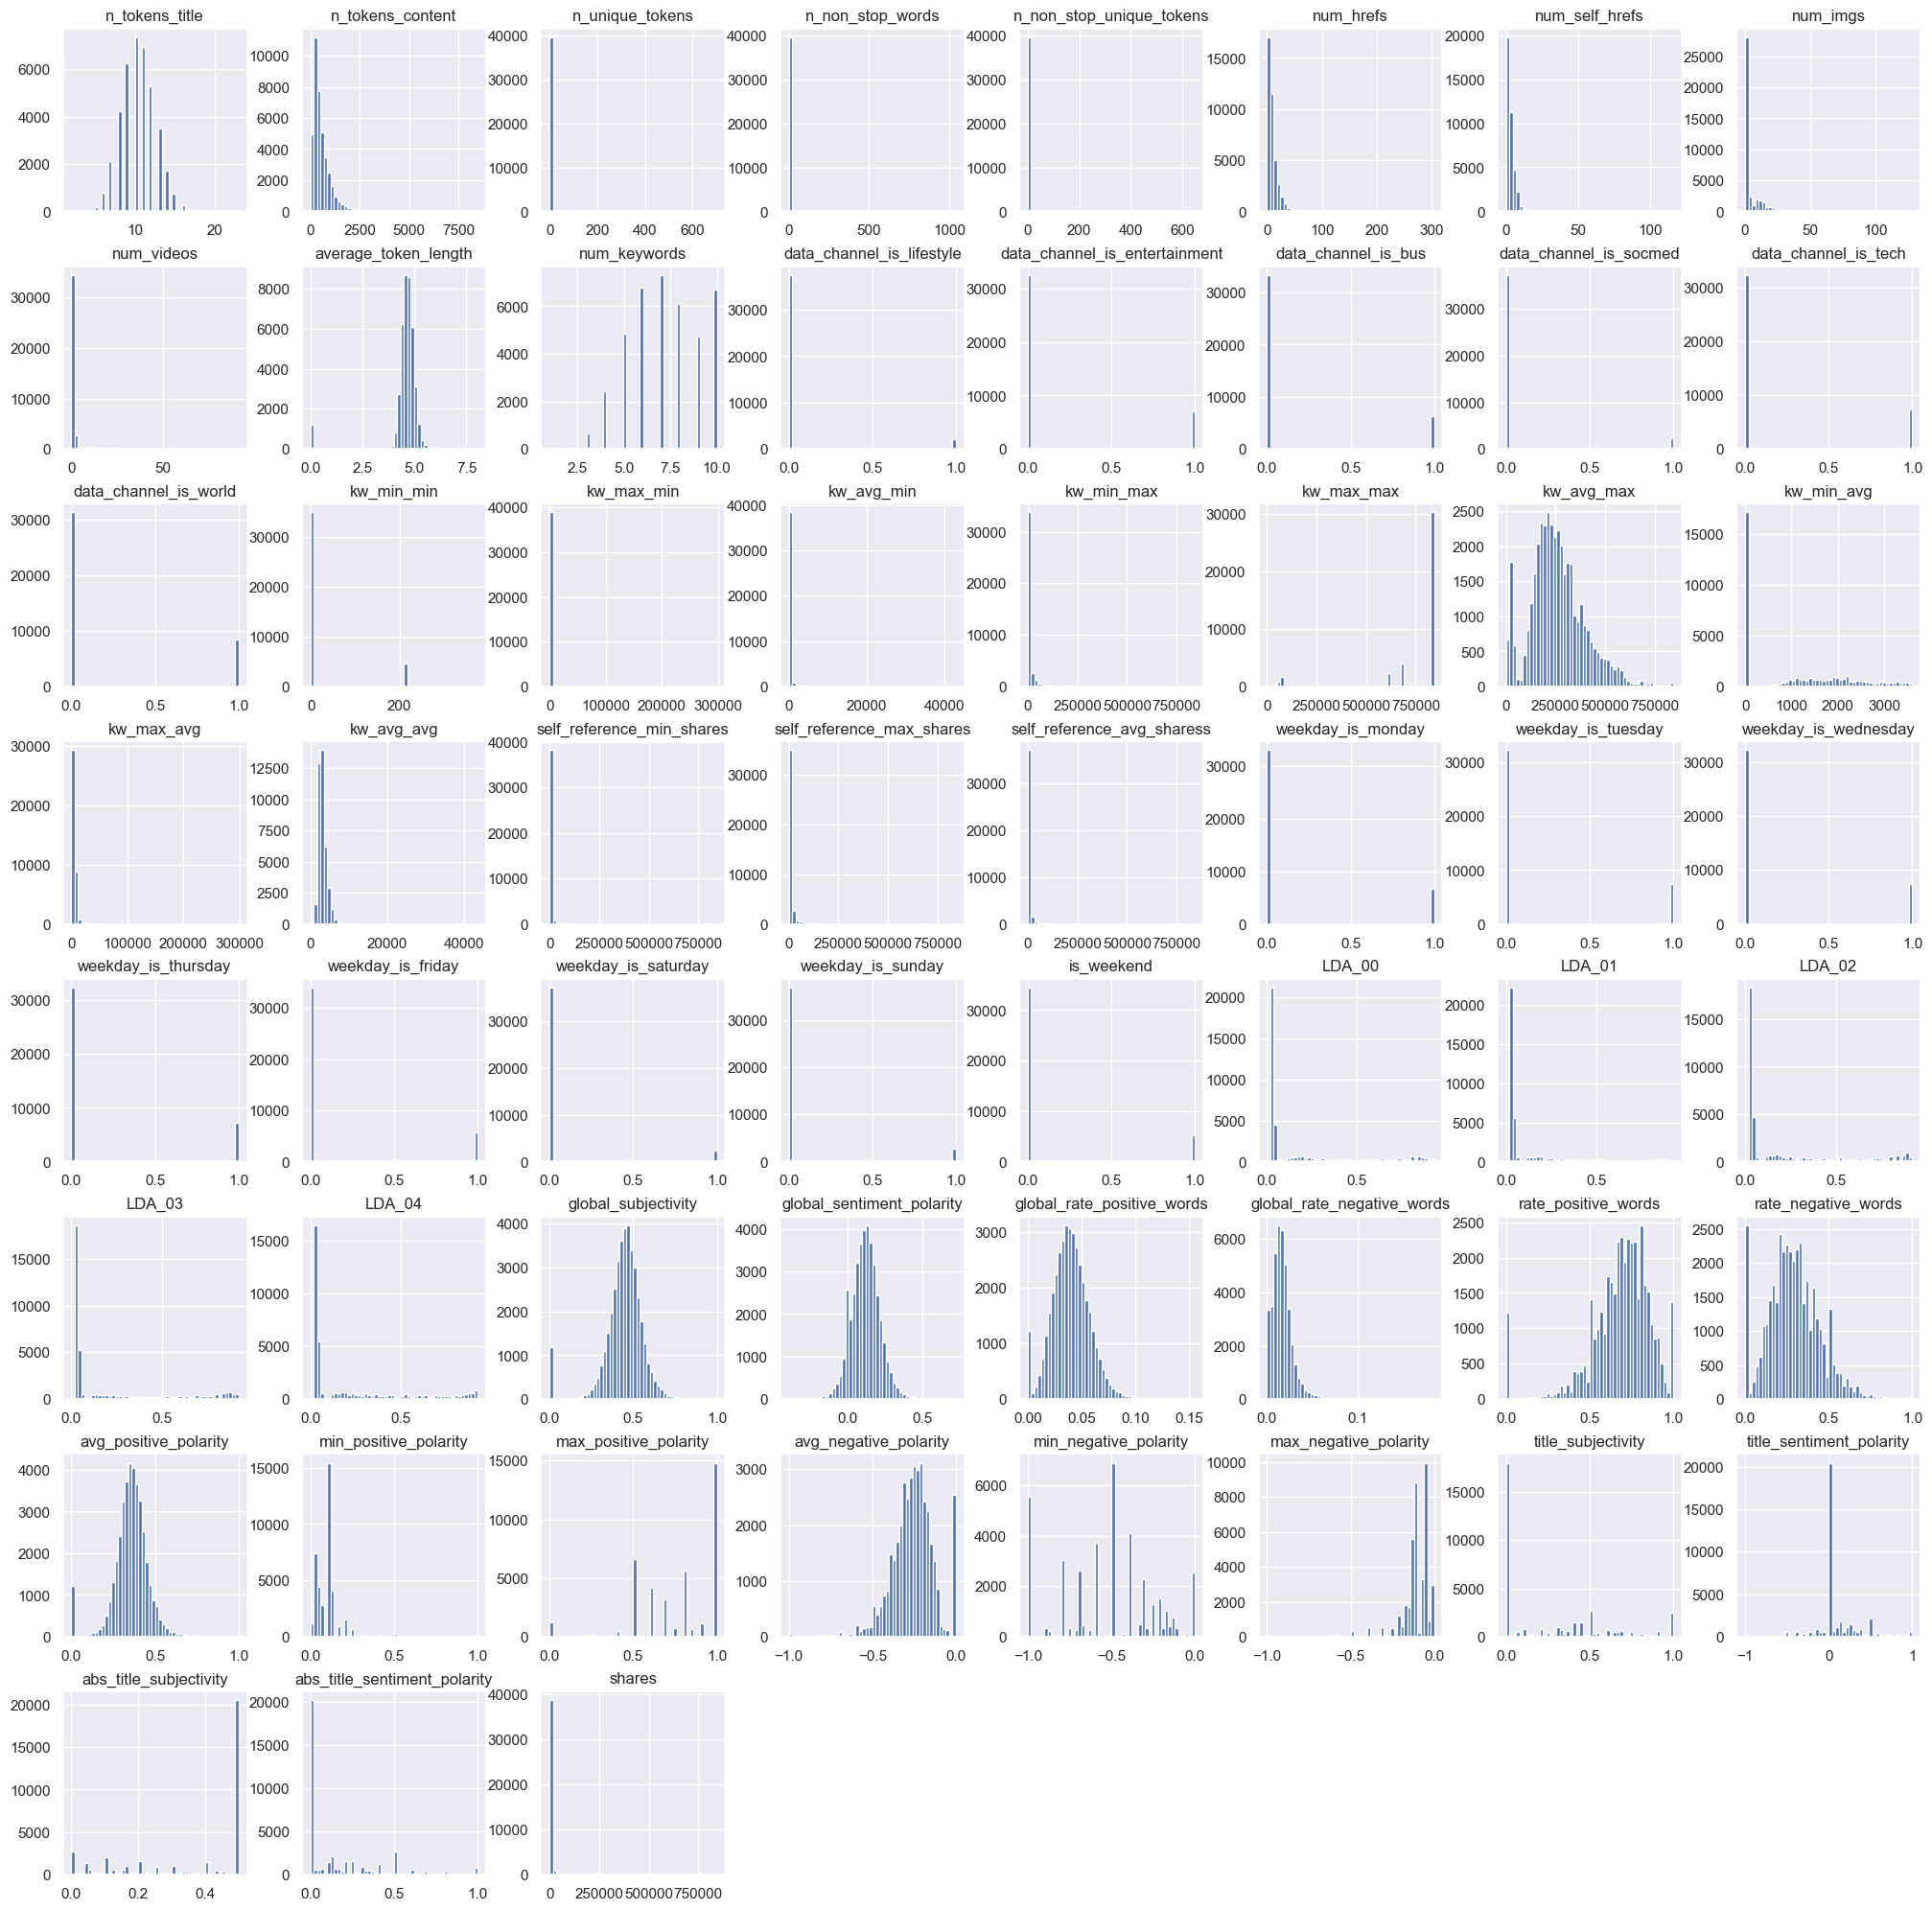

A couple of comments: Different scales, some features do not have the necessary values to see generate a histogram
for example week_is_monday altough is a numeric value, is a binary feature , but others like num_keywords have few categories
so the histogram is not possible to see a well-generated curve For a first model, we'll take into account the following numerical features:
n_tokens_content num_hrefs average_token_length kw_avg_max global_subjectivity , global_sentiment_polarity , global_rate_positive_words , global_rate_negative_words
rate_positive_words , rate_negative_words avg_positive_polarity , avg_negative_polarity Binary features: data_channel_is_lifestyle, data_channel_is_entertainment,
data_channel_is_bus, data_channel_is_socmed data_channel_is_tech, data_channel_is_world , weekday_is_monday, weekday_is_tuesday, weekday_is_wednesday
Plotting correlation matrix


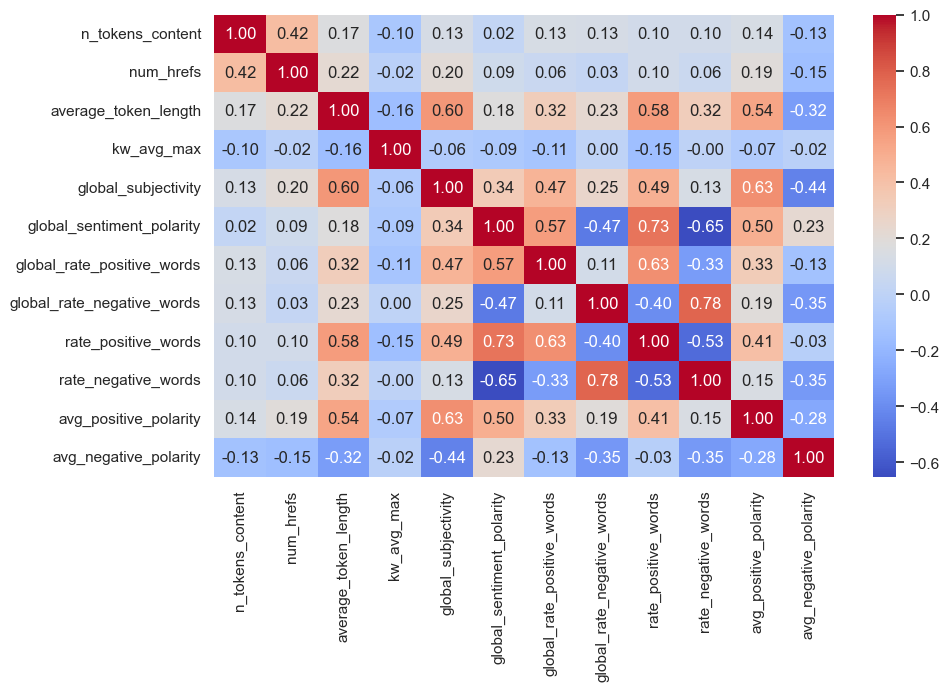

Other proposed plots


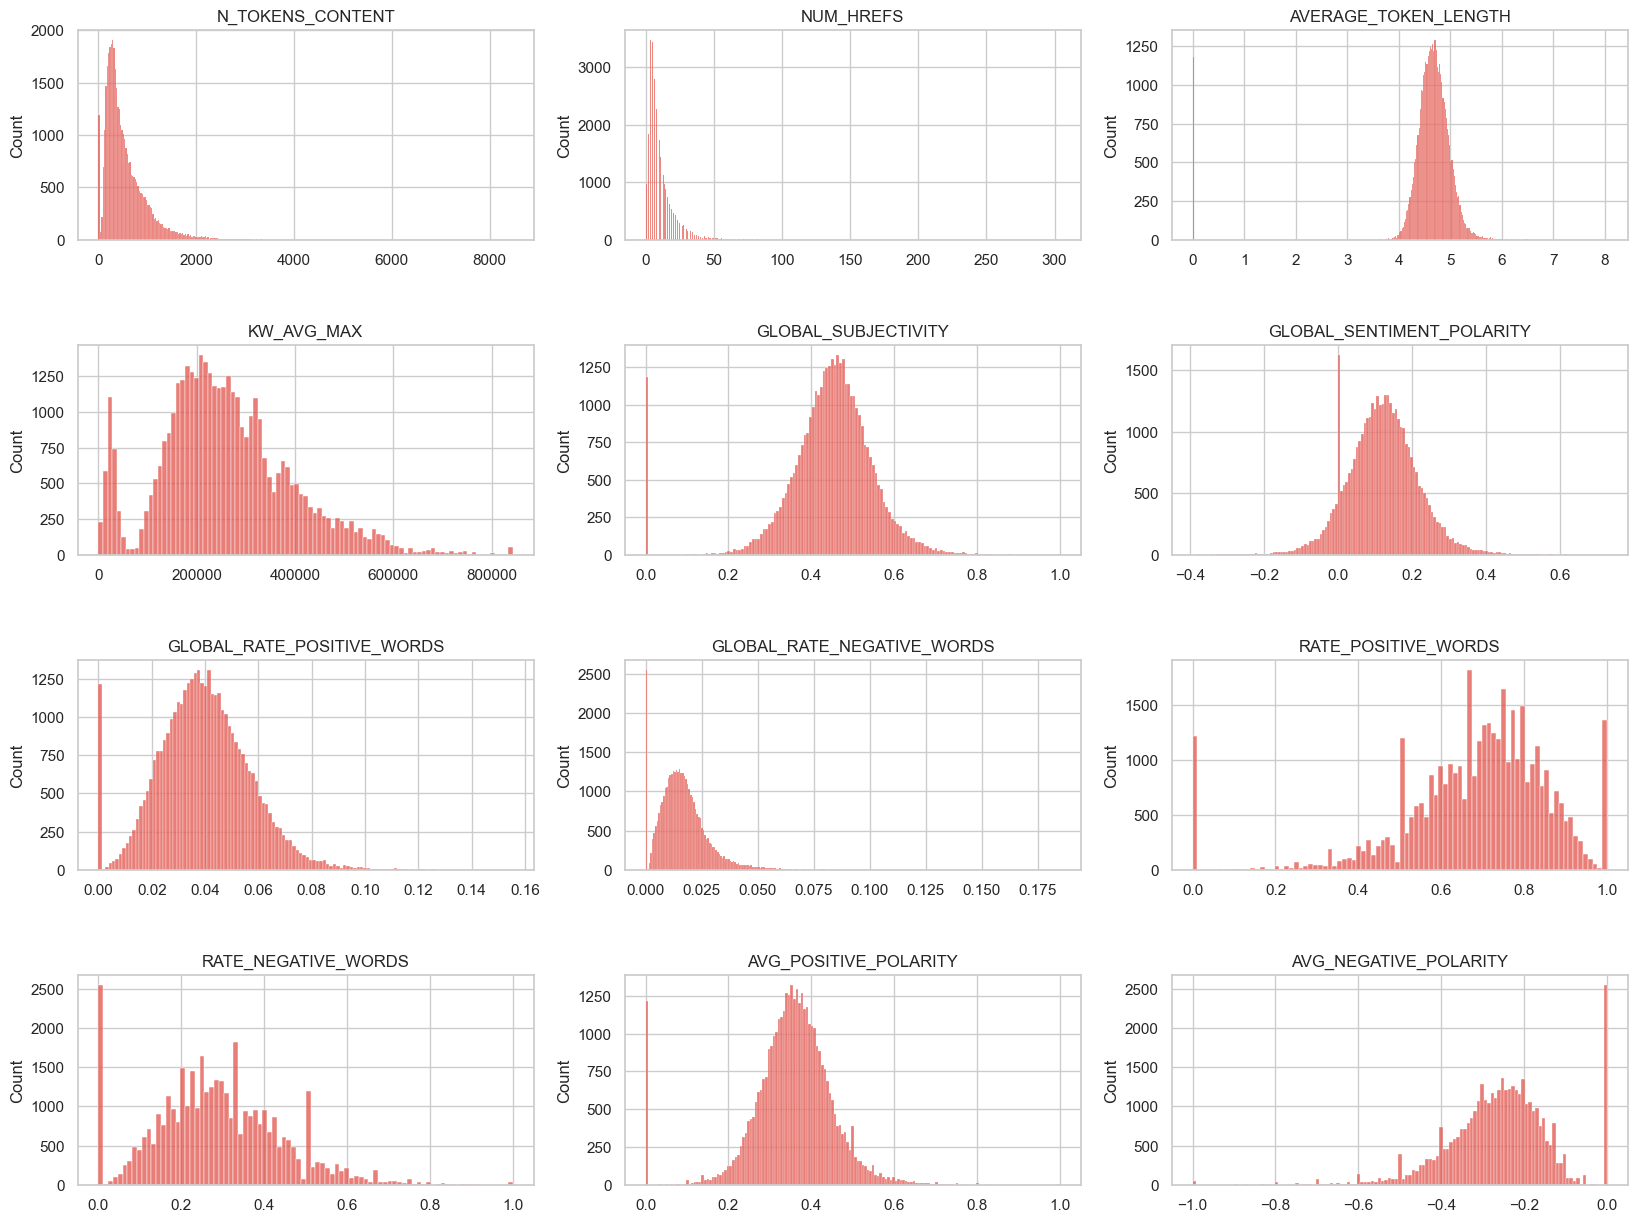

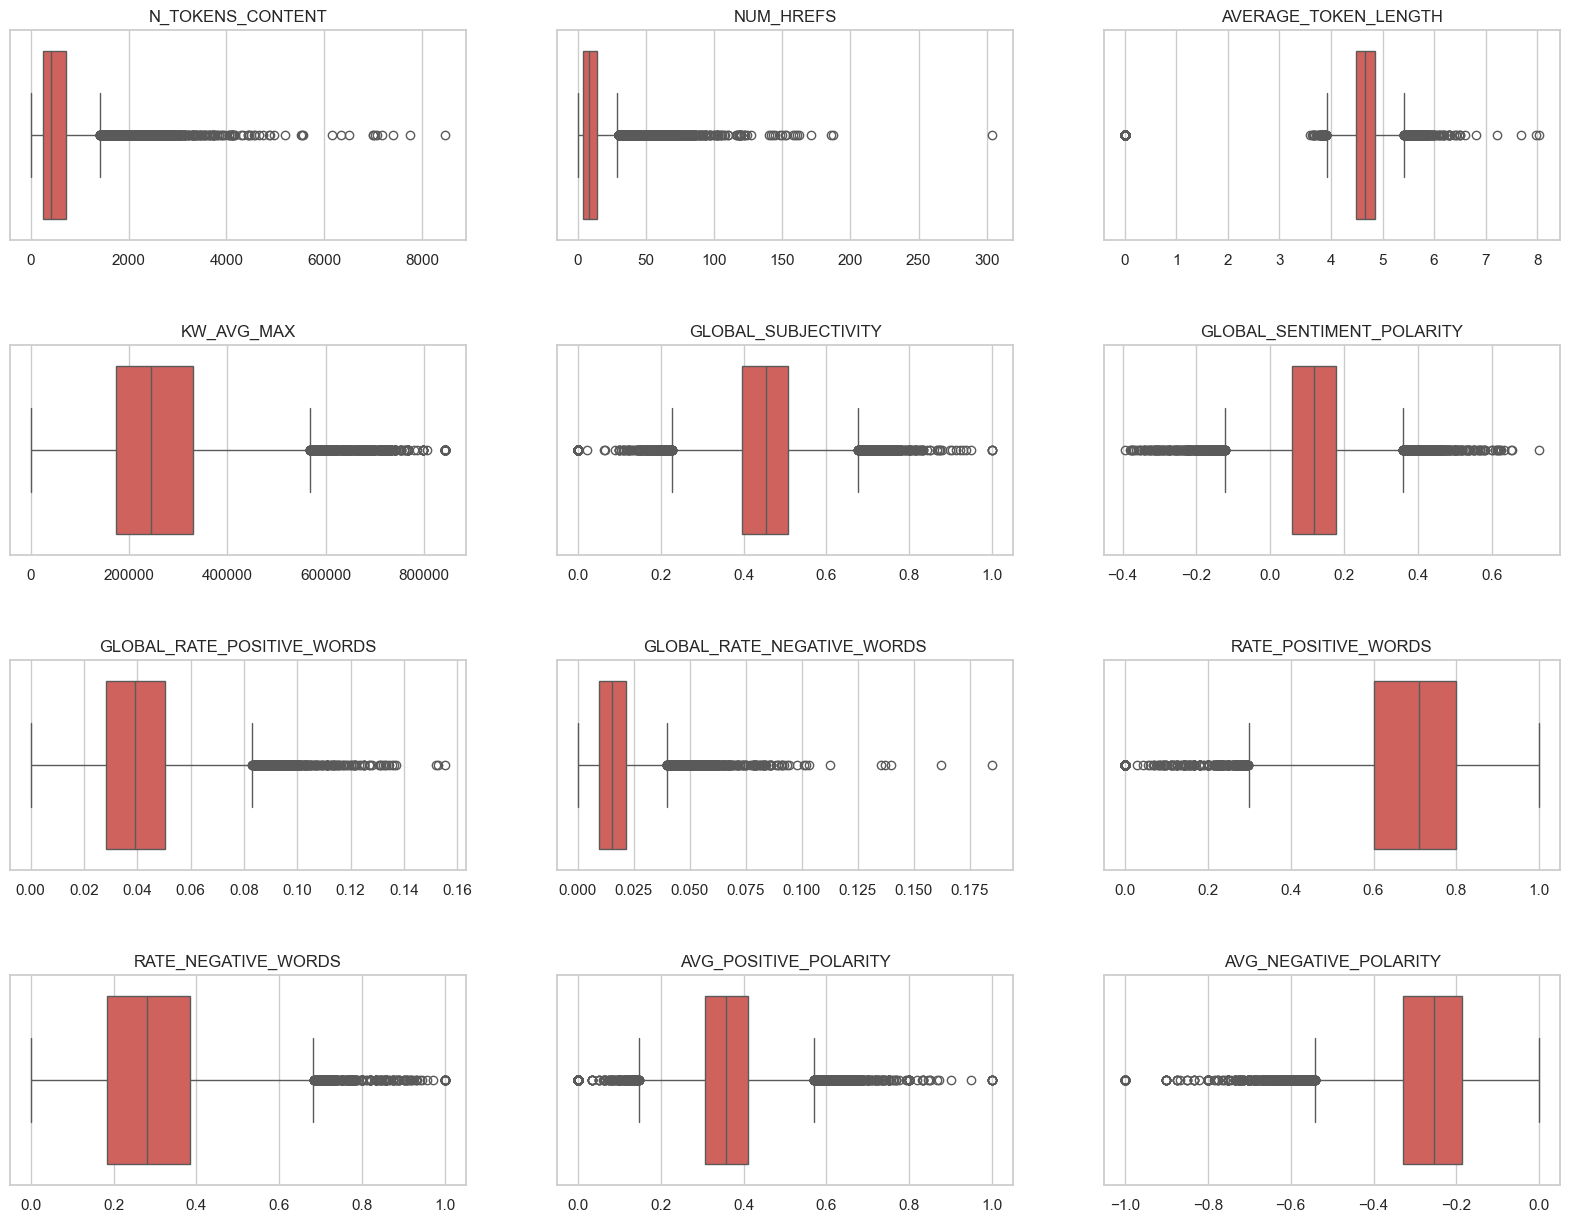

Transforming shares variable


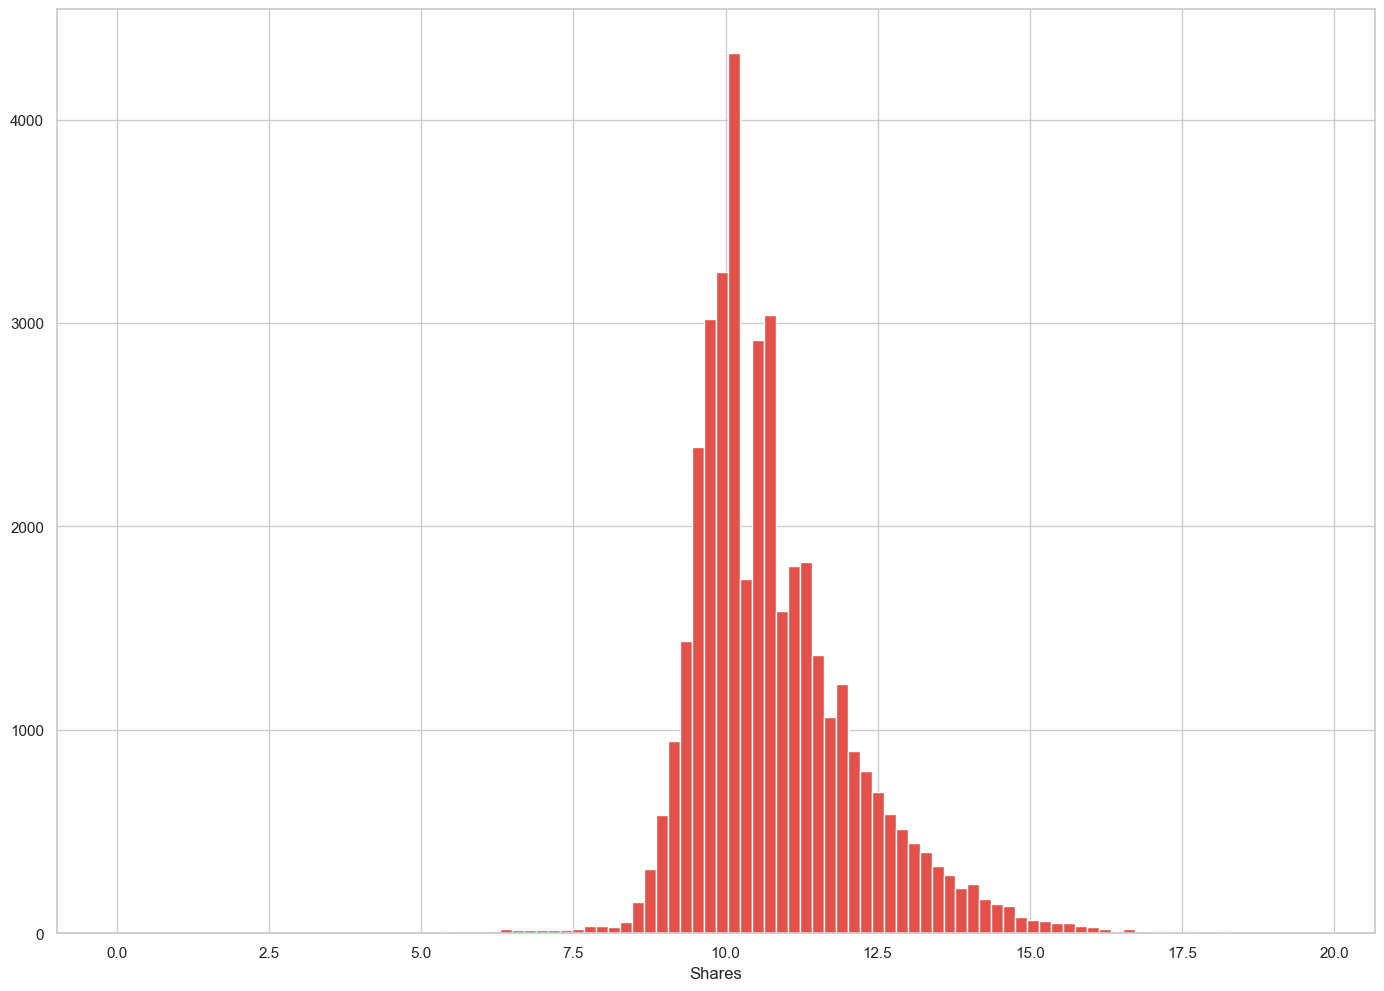

Applying tranformation to numerical features
*********************************************Transformaciones***************************************************


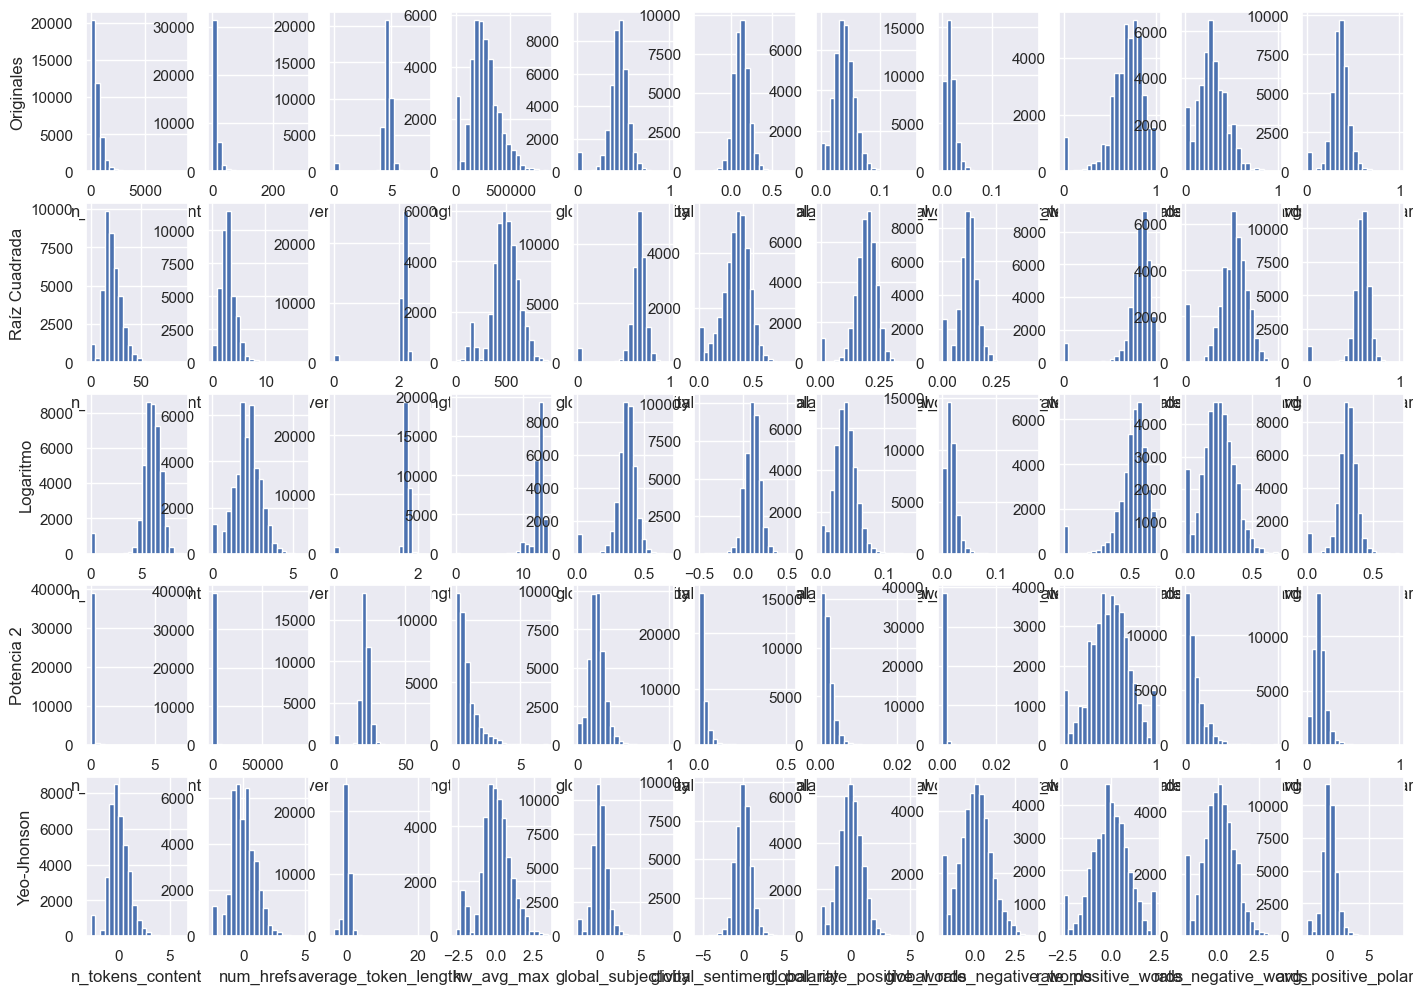

Applying tranformation to the last feature
As the last column named avg_negative_polarity has a lot of negative values, if we apply operations such as square root, or log2 
We will get error, so the only option we have is to apply Yeo-Johnson, let's check if that can help


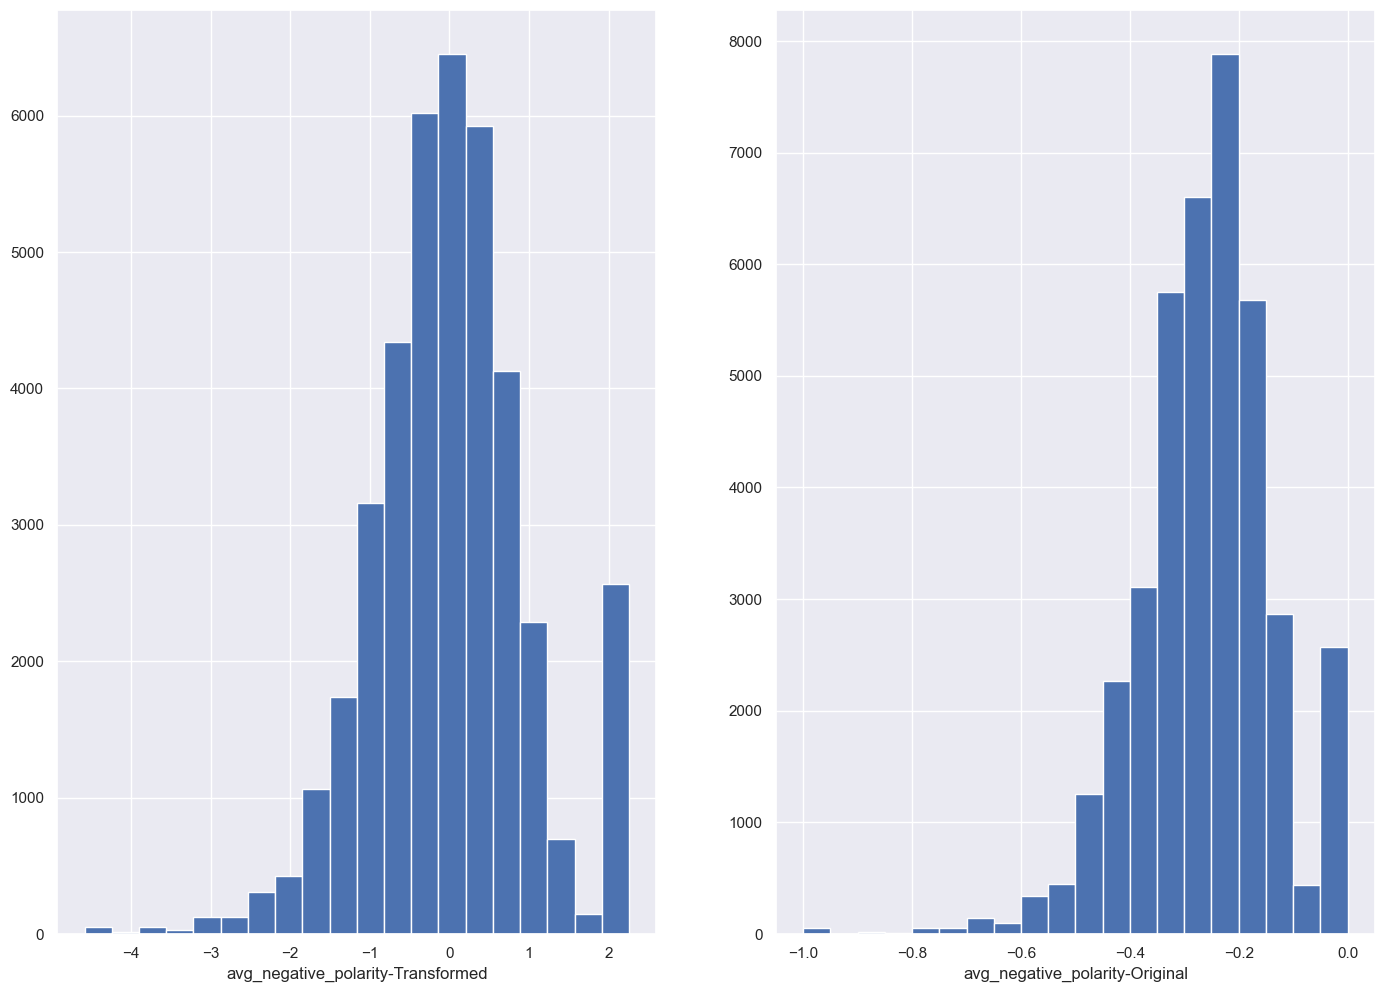

Puntos a destacar, podemos aplicar las siguientes transformaciones a las siguientes variables para corregir skew:
Númericas - Standard Scaler para que todos los rangos esten entre 0 y 1
num_hrefs - n_tokens_content -avg_positive_polarity - global_subjectivity - Logaritmo - np.log1p
average_token_length - global_sentiment_polarity - Original 
kw_avg_max - global_rate_positive_words- Raiz Cuadrada
global_rate_negative_words - rate_positive_words -rate_negative_words- Yeo Johnson 

Training------
RandomForestRegressor(max_depth=16, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=160, random_state=42)

Testing-------
Error Cuadrático Medio: 1.4825105532379537

Cross Validation -----
Average Accuracy with CV: 0.15668938377768532


In [76]:
filepath=r'C:/Users/balde/Desktop/MAESTRIA MNA/Contribs/MLOPSGrupo3/data/raw/online_news_popularity.csv'

model = OnlineShares(filepath)
model.load_data()
X_train_scaled, X_test_scaled, y_train, y_test = model.preprocess_data()
print()
print('Training------')
model_reg = model.train_model(X_train_scaled, y_train)
print(model_reg)
print()
print('Testing-------')
model.evaluate_model(model_reg, X_test_scaled , y_test)
print()
print('Cross Validation -----')
model.cross_validate_model()